# COMP5318 Assignment 2
**Group number**: Group46<br>

**Group members**: <br>
Xing Xing(500390560), <br>
YuanYuan Lin(500595497), <br>

**Topic**: CIFAR-100, classification, https://www.cs.toronto.edu/~kriz/cifar.html. <br>

**Start Date**: 14 OCT 2021 <br>
**Finish Date**: 1 NOV 2021 <br>

**System Information**:
- System: Mac Darwin <br>
- Machine: x86_64 <br>
- Processor: i386 <br>
- Memory: 8 GB <br>
- CPU: 8-core <br>
- GPU: Python 3 Google Compute Engine backend <br>


# 1. Import images

There are 2 image datasets namely train and test which stored in numpy array. Load data from keras library which will download data from https://www.cs.toronto.edu/~kriz/cifar.html which is same with the url provided by assignment description.Please run this cell before further execution
- **load_from_keras()**: load x_train, y_train, x_test, y_test data into numpy array



In [ ]:
!pip install pyyaml h5py

import os
import pickle
import numpy as np
from tensorflow.keras.datasets import cifar100

#=================================
# a. Load data from Keras 
#=================================
def load_from_keras():
  # log
  print("load_from_keras(): start loading ... ") 
  # load directly from package 
  (x_train,y_train), (x_test, y_test) = cifar100.load_data()
  return (x_train,y_train), (x_test, y_test)

#===========
# Load data 
#===========
(x_train, y_train), (x_test, y_test) = load_from_keras()

# describe data
print("load_data(): train_data loaded, " + str(x_train.shape))
print("load_data(): train_label loaded, " + str(len(y_test)))
print("load_data(): test_data loaded, " + str(x_test.shape))
print("load_data(): test_label loaded, " + str(len(y_test)))

load_from_keras(): start loading ... 
load_data(): train_data loaded, (50000, 32, 32, 3)
load_data(): train_label loaded, 10000
load_data(): test_data loaded, (10000, 32, 32, 3)
load_data(): test_label loaded, 10000


# 2. Preprocessing

###2.1 Global Helper functions
Include: GPU managment, image overview, Neural network helper functions. Please run these cells in numeric order before further execution. 
- **clear_ram()**: clear ram session and free ram memory 
- **plot_epoch_accuracy(record)**: plot training_accuracy and yest_accuracy by increase epoch 
- **show_img(x_train)**: show some (2*5) sample images

show_img(): show sample images ...


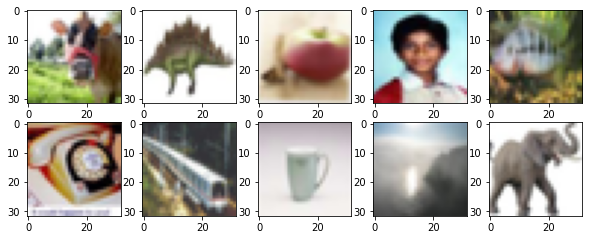

In [ ]:
import gc 
from matplotlib import pyplot as plt
from tensorflow.compat.v1 import ConfigProto, Session
from tensorflow.compat.v1.keras.backend import get_session, clear_session, set_session

#========================
# Gpu session management
#========================
def clear_ram():
  # remove things in RAM
  session = get_session()
  clear_session()

  # Close existing session 
  session.close()
  session = tf.compat.v1.keras.backend.get_session()

  # Create new RAM session 
  config = ConfigProto()
  config.gpu_options.per_process_gpu_memory_fraction = 1
  config.gpu_options.visible_device_list = "0"
  set_session(Session(config=config))

#====================
# plot epoch diagram
#====================
# plot epoch and accuracy diagram for train and test
def plot_epoch_accuracy(record):
  plt.plot(record.history['accuracy'], label='Training')
  plt.plot(record.history['val_accuracy'], label = 'Testing')
  plt.xlabel('Epoches')
  plt.ylabel('Accuracy')
  #plt.imshow()
  plt.show()

# show an image 
def show_img(x_train):
  # 
  print("show_img(): show sample images ...")
  # set initial size 
  plt.figure(figsize=(10,10))

  # show 10 pictures in 1 grid
  for i in range(0,10):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    tmp = x_train[i]
    plt.imshow(tmp)
  plt.show()


# show sample images * 10
show_img(x_train)



#### 2.2 Preprocessing for SVM <br>
- **RGB_to_greys(data)**: RGB np array to grescale 1 dim np array <br>
- **STD(data)**: standardise entire data<br>
- **NORM(data)**: keep image pixels between 0 to 1 as float32 <br>
- **find_best_pca(data)**: find the most effective n_components <br>
- **PCA_deduction(x_train, n_comp)**: dimension deduction to speed up <br>
- **process_svm_label(label)**: change y_train, y_test to numeric label for svm

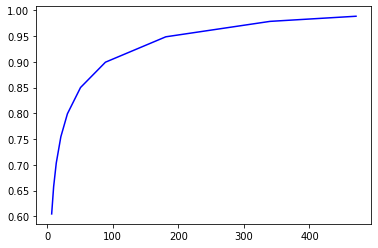

n_components: percentage
[0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99]
n_components: number
[7, 10, 14, 21, 31, 51, 89, 181, 340, 471]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

#========================
# grey scale and flatten 
#========================
# RGB to Grey scale image = 0.2989*R + 0.5870*G + 0.1140*B
# shape (n, 32, 32) to (n, 1024)
def RGB_to_greys(data):
  grey = []
  # for all image in dataset transfer to grey
  for i in (range(0, len(data))):
    image = data[i]
    tmp = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    grey.append(tmp)
  # as numpy array
  grey = np.asarray(grey, dtype=np.float32)
  grey = grey.reshape(len(grey), 1024)
  return grey

#===============
# STD + NORM
#===============
# Standardise entire data
def STD(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

# Normalise entire data 
def NORM(data):
    transformer = Normalizer().fit(data)
    return transformer.transform(data)

#===========================
# Dimension deduction - PCA
#===========================
# find best pca parameter
def find_best_pca(data):
  # find out best n_components for PCA
  n_comp = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99]
  explain_list = []
  dim_list = []
  for i in n_comp:
    pca = PCA(n_components = i).fit(data)
    # cumsum variance explained
    explain_list.append(np.sum(pca.explained_variance_))
    dim_list.append(pca.n_components_)
  # show elbow image
  plt.plot(dim_list, explain_list, color = "Blue", linewidth = 1.5)
  plt.show()
  print("n_components: percentage")
  print(n_comp)
  print("n_components: number")
  print(dim_list)

#===============
# Label for SVM
#===============
def process_svm_label(label):
  recoded_label = []
  for i in label:
    recoded_label.append(i[0])
  recoded_label = np.array(recoded_label)
  return recoded_label

#=======================
# Preprocessing for svm 
#=======================
import warnings
warnings.filterwarnings('ignore')

# Convert RGB to Grey and flatten 
grey_x_train = RGB_to_greys(x_train)
grey_x_test = RGB_to_greys(x_test)

# Standardisation 
std_x_train = STD(grey_x_train)
std_x_test = STD(grey_x_test)

# Normalisation 
norm_x_train = NORM(std_x_train)
norm_x_test = NORM(std_x_test)

# By observe the diagram we choose 181 (95% variance) as the n_components
find_best_pca(norm_x_train)

# [!!!] ONLY use x_train(norm_x_train) to train PCA 
# 0.95% variance kept = 181 components 
pca_transformer = PCA(n_components = 89).fit(norm_x_train)

# produced dimension reduced data
svm_x_train = pca_transformer.fit_transform(norm_x_train)
svm_x_test = pca_transformer.fit_transform(norm_x_test)

# check if label adapt SVM 
svm_y_train = process_svm_label(y_train)
svm_y_test = process_svm_label(y_test)


#### 2.3 Preprocessing for Neural Networks <br>
Preprocessing for CNN and VGG16, and hot code y_train and y_test so that NN could adapt
- **normalisation()**: keep image pixels between 0 to 1 as float <br>
- **one_hot_code**: hot code all labels <br>




In [ ]:
# IF NO GPU DON'T RUN THIS 
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import ConfigProto, Session
from tensorflow.compat.v1.keras.backend import get_session, clear_session, set_session

#===============
# Normalisation 
#===============
def normalisation(train, test):
  train = train - np.mean(train, axis = 0)
  train = train / np.std(train, axis = 0)
  test = test - np.mean(test, axis = 0)
  test = test / np.std(test, axis = 0)
  return (train, test)

#=====================
# One Hot Code labels
#=====================
from tensorflow.keras.utils import to_categorical
def one_hot_code(y_train, y_test):
  label1 = to_categorical(y_train, 100)
  label2 = to_categorical(y_test, 100)
  return label1, label2

#===========================
# Prepare image for Network 
#===========================

# if session exists close 
if (get_session()):
  session = get_session()
  session.close()

# else: create session 
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# normalisation 
NN_x_train, NN_x_test = normalisation(x_train, x_test)

# One hot code labels
NN_y_train, NN_y_test = one_hot_code(y_train, y_test)


# 3. Models
Model building functions which will be used in part 4, 5 and 6. Please run these 3 cells before further execution 
- 3.1 SVM: support vector machine 
- 3.1 LeNet: LeNet-5 inspired by LeCun
- 3.3 VGG16: double_convolutional layer neural network 

#### 3.1 SVM

In [ ]:
#=====
# SVM
#=====
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# SVM data useage: svm_x_train, svm_y_train, svm_x_test, svm_y_test

# SVM classifier with sklearn
def svm(svm_x_train, svm_y_train, svm_x_test, svm_y_test, C, kernel, gamma, max_iter):
    start_time = time.time()
    
    # Build classifier and train 
    svm = SVC(C = C, kernel = kernel, gamma = gamma, max_iter = max_iter)
    svm.fit(svm_x_train, svm_y_train)
    
    # Prediction on x_test
    result = svm.predict(svm_x_test)
    end_time = time.time()

    # record runing time
    time_diff = round((end_time - start_time)/60, 2)
    
    # individual model result
    score = accuracy_score(result, svm_y_test)
    #print("svm(): test result: " + str(score*100) + "% \n")
    
    return score, time_diff


#### 3.2 LeNet-5

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization

# =====================
# Building LeNet Model
# =====================
def LeNet(drop = 0.5, summary = False):
  # CNN container 
  LeNet = Sequential()
  decay = 0.01
  
  # ==================================== Block 1 ==================================== 
  # Convo-1: filter = 64，kernel_size = 3*3
  LeNet.add(Conv2D(filters = 32, kernel_size = (5, 5), activation='relu', data_format='channels_last', padding='same', input_shape=(32,32,3)))
  LeNet.add(BatchNormalization())
  LeNet.add(Dropout(rate = drop))

  # Pooling-1: pool size = 2*2, trides=2
  LeNet.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2), padding = 'same', name="Pooling-1"))

  # ==================================== Block 2 ====================================
  # Convo-2: filter = 128，kernel_size = 3*3
  LeNet.add(Conv2D(filters = 64, kernel_size = (5, 5), activation='relu', 
                   data_format='channels_last', padding='same', kernel_regularizer = l2(decay)))
  LeNet.add(BatchNormalization())
  LeNet.add(Dropout(rate = drop))

  LeNet.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2), padding = 'same', name="Pooling-2"))

  # ==================================== Block 3 ==================================== 
  LeNet.add(Conv2D(filters = 128, kernel_size = (5, 5), activation='relu', 
                   data_format='channels_last', padding='same', kernel_regularizer = l2(decay)))
  LeNet.add(BatchNormalization())
  LeNet.add(Dropout(rate = drop))
  LeNet.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2), padding = 'same', name="Pooling-3"))

  # ==================================== Block 3 ==================================== 

  LeNet.add(Flatten())
  LeNet.add(Dense(1024, activation=tf.nn.relu))
  LeNet.add(BatchNormalization())
  #LeNet.add(Dropout(rate = drop))
  LeNet.add(Dense(100, activation=tf.nn.softmax))

  if (summary == True):
    print(LeNet.summary())
  
  return LeNet

def train_LeNet(x_train, y_train, x_test, y_test, lenet, opt, batch_size = 125, max_epoch = 100, early_stop = True, plot = True, verb = 0):
  # steps 
  stp = x_train.shape[0] // batch_size
  
  #data augmentation = image rotation, hori/verti shift, hori/verti flip
  image_generator = ImageDataGenerator(
      rotation_range = 20, 
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      horizontal_flip=True,
  )
  # train generator and produce flow 
  image_generator.fit(x_train)
  train = image_generator.flow(x_train, y_train, batch_size = batch_size)

  # early stopping to avoid waste time 
  early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, mode = 'auto')

  lenet.compile(loss = 'categorical_crossentropy',
              optimizer = opt, 
              metrics = ['accuracy'])

  # train model 
  if (early_stop == True):
    record = lenet.fit(train, steps_per_epoch = stp,
                     epochs = max_epoch,
                     validation_data = (x_test, y_test), 
                     callbacks = [early_stopping], 
                     shuffle = True,
                     verbose = verb)
  else:
    record = lenet.fit(train,
                     epochs = max_epoch,
                     validation_data = (x_test, y_test), 
                     shuffle = True,
                     verbose = verb)

  # Plot epoch diagram using helper function 
  if (plot == True):
    plot_epoch_accuracy(record) 
  
  return lenet, record

#### 3.3 VGG16

In [ ]:
#========
# VGG-16
#========
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization

# Build VGG-16 model 
def VGG16(kernel = 3, decay = 0.0005, summary = False):
  # container 
  VGG16 = Sequential()

  # ==================================== Block 1 ====================================
  # Convo: filter = 64
  VGG16.add(Conv2D(filters = 64, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same',
                 input_shape = (32,32,3), kernel_regularizer = l2(decay), 
                 name="Convo-1-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 30% 
  VGG16.add(Dropout(rate = 0.3, name = "Drop-1-1"))

  # Convo: filter = 64
  VGG16.add(Conv2D(filters = 64, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-1-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-1: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-1-1"))

  # ==================================== Block 2 ====================================
  # Convo: filter = 128
  VGG16.add(Conv2D(filters = 128, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-2-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 30% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-2-1"))

  # Convo: filter = 128
  VGG16.add(Conv2D(filters = 128, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-2-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-2: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-2-1"))

  # ==================================== Block 3 ====================================
  # Convo: filter = 256
  VGG16.add(Conv2D(filters = 256, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-3-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-3-1"))

  # Convo: filter = 256
  VGG16.add(Conv2D(filters = 256, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-3-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-3-2"))

  # Convo: filter = 256
  VGG16.add(Conv2D(filters = 256, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-3-3"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-2: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-3-1"))

  # ==================================== Block 4 ====================================
  # Convo: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-4-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-4-1"))

  # Convo-4: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-4-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-4-2"))

  # Convo-5: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-4-3"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-2: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-4-1"))

  # ==================================== Block 5 ====================================
  # Convo: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-5-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-5-1"))

  # Convo-4: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-5-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-5-2"))

  # Convo-5: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-5-3"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-2: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-5-1"))
  VGG16.add(Dropout(rate = 0.5 , name = "Drop-5-3"))

  # ==================================== Block 6 ====================================

  VGG16.add(Flatten(name="Flatten-1"))
  # Full_connect 
  VGG16.add(Dense(units = 512, activation='relu', kernel_regularizer = l2(decay)))
  # Normalisation 
  VGG16.add(BatchNormalization())
  VGG16.add(Dropout(rate = 0.5 , name = "Drop-6-3"))
  VGG16.add(Dense(units = 100, activation='softmax'))

  # print VGG-16 structure 
  if (summary == True):
    print(VGG16.summary())

  return VGG16 


# Train VGG16 model
def train_VGG16(x_train, y_train, x_test, y_test, VGG_16, learning_rate = 0.1, batch_size = 125, max_epoch = 100, early_stop = False, plot = False, verb = 1):
  # steps for every epoch 
  stp = x_train.shape[0] // batch_size

  #data augmentation = image rotation, hori/verti shift, hori/verti flip
  image_generator = ImageDataGenerator(
      rotation_range = 20, 
      width_shift_range = 0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
  )
  # train generator and produce flow 
  image_generator.fit(x_train)
  train = image_generator.flow(x_train, y_train, batch_size = batch_size)


  # VGG16 use SGD as optimizer 
  sgd_opt = SGD(learning_rate = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

  # compile model 
  VGG_16.compile(loss = 'categorical_crossentropy', 
                optimizer = sgd_opt, 
                metrics = ['accuracy'])

  # generate schedulaer 
  def dynamic_lr(epoch):
    return learning_rate * (0.5 ** (epoch // 20))
  
  schedular = LearningRateScheduler(dynamic_lr)

  # early stopping to avoid waste time 
  if (early_stop == True):
    early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 8, verbose = 0, mode = 'auto')
    call_back = [early_stopping, schedular]
  else:
    call_back = [schedular]
  
  
  # training process in a for loop with learning rate drop every 25 epoches.
  record = VGG_16.fit(train,
                      steps_per_epoch = stp,
                      epochs = max_epoch,
                      validation_data = (x_test, y_test), 
                      callbacks = call_back, 
                      verbose = verb)
  
  # Plot epoch diagram using helper function 
  if (plot == True):
    plot_epoch_accuracy(record) 
  
  return VGG_16, record

  VGG_16 = VGG16(kernel = 3, decay = 0.0005, summary = False)
  VGG_16, record = train_VGG16(x_train, y_train, 
              x_test, y_test, 
              VGG_16, learning_rate = best_lr, 
              batch_size = best_batch, max_epoch = 200, 
              early_stop = False, plot = True, 
              verb = 1)


#4. Fine Tuning [Skippable]
Tuning processes cost significant time and RAM capability to finish. For saving markers time and makeing markers' work easier, the cells in part 4 could be skipped and optionally runing.

a. SVM Tuning <br>
b. CNN Tuning <br>
c. VGG16 Tuning <br>

#### 4.1 SVM Hyperparameter Tunning 

In [ ]:
#============
# SVM Tuning 
#============
import time
import warnings
from sklearn.model_selection import KFold

# find best SVM parameters use grid search with 3-fold cross validation
def svm_stun(x_train, y_train, para_grid, n =3):
  # log
  print("svm_stun(): start SVM stun...")

  # record best parameter/score
  best_para = []
  best_score = 0

  # Record start time
  start_time = time.time()

  # Hyperparameter lists
  max_iter = 200
  C_list = para_grid['C']
  gamma_list = para_grid['gamma']
  kernel_list = para_grid['kernel']

  # Manually grid search for hyperparameters 
  for C in C_list:
    for gamma in gamma_list: 
      for kernel in kernel_list:
        # record average accuracy 
        sum_acc = 0

        # log
        print("svm_stun(): current parameters = {C:" + str(C) + ", gamma: "+ str(gamma) + ", kernel: " + kernel + "}")

        # 3-fold cross validation
        fold_number = 1

        # create 3 fold indexes 
        fold = KFold(n_splits = n, shuffle = True)
        fold_indexes = fold.split(x_train, y_train)

        for train_ind, valid_ind in fold_indexes:

          # create train and validation 
          tmp_x_train = np.array(x_train)[train_ind]
          tmp_x_valid = np.array(x_train)[valid_ind]
          tmp_y_train = np.array(y_train)[train_ind]
          tmp_y_valid = np.array(y_train)[valid_ind]

          # fit current svm and get accuracy 
          tmp_score, tmp_time = svm(tmp_x_train, tmp_y_train, tmp_x_valid, tmp_y_valid, C, kernel, gamma, max_iter)
          sum_acc = sum_acc + tmp_score

          # log
          print("....CV(): fold " + str(fold_number) + "/3, accuracy = " + str(tmp_score))
          fold_number = fold_number + 1
        
        # if better sccuracy replace best score 
        if (sum_acc/3 > best_score):
          best_para = [C, gamma, kernel]
        print("....CV(): Average Accuracy = " + str(sum_acc/3))

  return best_para

    
# manually select para_grid 
para_grid = {'C': [1, 2, 3, 4, 5], 'gamma': [3, 5] ,'kernel': ['rbf']}
svm_best_para = svm_stun(svm_x_train, svm_y_train, para_grid, n = 3)

svm_stun(): start SVM stun...
svm_stun(): current parameters = {C:1, gamma: 3, kernel: rbf}
....CV(): fold 1/3, accuracy = 0.1751964960700786
....CV(): fold 2/3, accuracy = 0.1759764804703906
....CV(): fold 3/3, accuracy = 0.17838713548541943
....CV(): Average Accuracy = 0.17652003734196287
svm_stun(): current parameters = {C:1, gamma: 5, kernel: rbf}
....CV(): fold 1/3, accuracy = 0.18011639767204657
....CV(): fold 2/3, accuracy = 0.18005639887202257
....CV(): fold 3/3, accuracy = 0.1810872434897396
....CV(): Average Accuracy = 0.18042001334460292
svm_stun(): current parameters = {C:2, gamma: 3, kernel: rbf}
....CV(): fold 1/3, accuracy = 0.1894762104757905
....CV(): fold 2/3, accuracy = 0.1870762584748305
....CV(): fold 3/3, accuracy = 0.18570742829713188
....CV(): Average Accuracy = 0.18741996574925093
svm_stun(): current parameters = {C:2, gamma: 5, kernel: rbf}
....CV(): fold 1/3, accuracy = 0.17951640967180657
....CV(): fold 2/3, accuracy = 0.18149637007259856
....CV(): fold 3/3,

In [ ]:
print("svm_stun(): Best parameter of SVM is" + str(svm_best_para))

svm_stun(): Best parameter of SVM is[3, 5, 'rbf']


### 4.2 LeNet Hyperparameter Tunning

In [ ]:
#==============
# LeNet Tuning 
#==============
import time
import warnings
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# get all type of optimizers
def generate_opts(lr):
  opts_list = []
  opts_list.append(SGD(learning_rate = lr))
  opts_list.append(Adadelta(learning_rate = lr))
  # adaptive optimizer
  opts_list.append(Adam())
  opts_list.append(RMSprop())
  return opts_list  

# LeNet hyper parameter tuning 
def LeNet_tuning(x_train, y_train):
  print("LeNet_tuning(): start....")
  # Build parameter matrix
  learning_rate = [0.09, 0.1, 0.11]
  batch_size_list = [10, 32, 80, 100, 150, 200]
  epoch = 40

  # 3 fold CV
  n = 3

  #record best parameter
  best_para = []
  best_score = 0

  # loop all learning rate 
  for lr in learning_rate:
    # generate optmizer list 
    opt_list = generate_opts(lr)

    n_name = 0
    # loop for all optimizers 
    for opt in opt_list:
      # loop for all batch sizes 
      for batch_size in batch_size_list:
        # tmp model 
        # set validation set 
        fold = KFold(n_splits = n, shuffle = True)
        fold_indexes = fold.split(x_train, y_train)

        print("LeNet_tuning(): current parameters = {lr:" + str(lr) + ", opt: "+ str(opt) + ", batch_size: " + str(batch_size) + "}")
        tmp_sum = 0
        fold_number = 1
        for train_ind, valid_ind in fold_indexes:
          # split validation dataset 
          tmp_x_train = np.array(x_train)[train_ind]
          tmp_x_valid = np.array(x_train)[valid_ind]
          tmp_y_train = np.array(y_train)[train_ind]
          tmp_y_valid = np.array(y_train)[valid_ind]

          tmp_model = LeNet(drop = 0.2, summary = False)

          # delete variables to free some ram 
          del train_ind
          del valid_ind
          
          tmp_model, record = train_LeNet(tmp_x_train, tmp_y_train, tmp_x_valid, tmp_y_valid, tmp_model, opt = opt, 
                                        batch_size = batch_size, max_epoch = epoch, early_stop = True, plot = False, verb = 0)
          
          del record

          tmp_result = tmp_model.evaluate(tmp_x_valid, tmp_y_valid, verbose=0)[1]
          del tmp_model
          

          # log 
          print("....CV(): fold " + str(fold_number) + "/3, accuracy = " + str(tmp_result))
          fold_number = fold_number + 1
          tmp_sum = tmp_sum + tmp_result

          # clear ram 
          clear_ram()
          # average acc

        tmp_sum = tmp_sum / 3
        clear_ram()

        # replace record if record broke
        if (tmp_sum > best_score):
          best_score = tmp_sum
          best_para = [lr, opt, batch_size]
        print("....CV(): Average Accuracy = " + str(tmp_sum))
        clear_ram()

  return best_score, best_para

LeNet_best_score, LeNet_best_para = LeNet_tuning(NN_x_train, NN_y_train)



LeNet_tuning(): start....
LeNet_tuning(): current parameters = {lr:0.09, opt: <keras.optimizer_v2.gradient_descent.SGD object at 0x7f7841ab0ad0>, batch_size: 10}
....CV(): fold 1/3, accuracy = 0.2357952892780304
....CV(): fold 2/3, accuracy = 0.2555948793888092
....CV(): fold 3/3, accuracy = 0.23310932517051697
....CV(): Average Accuracy = 0.24149983127911887
LeNet_tuning(): current parameters = {lr:0.09, opt: <keras.optimizer_v2.gradient_descent.SGD object at 0x7f7841ab0ad0>, batch_size: 32}
....CV(): fold 1/3, accuracy = 0.343793123960495
....CV(): fold 2/3, accuracy = 0.3337133228778839
....CV(): fold 3/3, accuracy = 0.3258730471134186
....CV(): Average Accuracy = 0.3344598313172658
LeNet_tuning(): current parameters = {lr:0.09, opt: <keras.optimizer_v2.gradient_descent.SGD object at 0x7f7841ab0ad0>, batch_size: 80}
....CV(): fold 1/3, accuracy = 0.3803924024105072
....CV(): fold 2/3, accuracy = 0.3836323320865631
....CV(): fold 3/3, accuracy = 0.37237489223480225
....CV(): Average

In [ ]:
print("LeNet-5_stun(): Best parameter of SVM is" + str(LeNet_best_para))

LeNet-5_stun(): Best parameter of SVM is[0.1, 32, '<keras.optimizer_v2.adadelta.Adadelta object at 0x7f4febb4d5d0>']


### 4.3 VGG16 Hyperparameter Tunning 

In [ ]:
import time
import warnings
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

def VGG16_tuning(x_train, y_train):
  print("VGG16_tuning: start....")
  # Build parameter matrix
  decay_list = [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
  learning_rate = [0.09, 0.1, 0.11]
  batch_size_list = [120, 125, 128, 130]
  epoch = 40

  # 3 fold CV
  n = 3

  #record best parameter
  best_para = []
  best_score = 0

  # manully expand grid 
  for decay in decay_list:

    # temporary model
    for lr in learning_rate:
      for batch_size in batch_size_list:
        fold = KFold(n_splits = n, shuffle = True)
        fold_indexes = fold.split(x_train, y_train)

        print("VGG_16_stun(): current parameters = {decay:" + str(decay) + ", lr: "+ str(lr) + ", batch_size: " + str(batch_size) + "}")
        
        # sum_tmp_score 
        tmp_sum = 0
        fold_number = 1

        for train_ind, valid_ind in fold_indexes:
          tmp_model = VGG16(kernel = 3, decay = decay, summary = False)

          # split validation dataset 
          tmp_x_train = np.array(x_train)[train_ind]
          tmp_x_valid = np.array(x_train)[valid_ind]
          tmp_y_train = np.array(y_train)[train_ind]
          tmp_y_valid = np.array(y_train)[valid_ind]

          # delete variables 
          del train_ind
          del valid_ind 

          # train for 100 batch with stop early
          tmp_model, record = train_VGG16(tmp_x_train, tmp_y_train, tmp_x_valid, tmp_y_valid, tmp_model, learning_rate = lr, 
                                          batch_size = batch_size, max_epoch = epoch, early_stop = True, plot = False, verb = 0)
          del record

          tmp_result = tmp_model.evaluate(tmp_x_valid, tmp_y_valid, verbose=0)[1]
          del tmp_model
          # log 
          print("....CV(): fold " + str(fold_number) + "/3, accuracy = " + str(tmp_result))
          fold_number = fold_number + 1
          tmp_sum = tmp_sum + tmp_result
          clear_ram()
        
        # average acc
        tmp_sum = tmp_sum / 3
        # Clear ram each run and avoid crashes 
        K.clear_session()
        clear_ram()

        # replace record if record broke
        if (tmp_sum > best_score):
          best_score = tmp_sum
          best_para = [decay, lr, batch_size]
        print("....CV(): Average Accuracy = " + str(tmp_sum))

  return best_score, best_para


VGG16_best_score, VGG16_best_para = VGG16_tuning(NN_x_train, NN_y_train)

VGG16_tuning: start....
VGG_16_stun(): current parameters = {decay:0.0005, lr: 0.09, batch_size: 125}
....CV(): fold 1/3, accuracy = 0.38927221298217773
....CV(): fold 2/3, accuracy = 0.39959201216697693
....CV(): fold 3/3, accuracy = 0.3966158628463745
....CV(): Average Accuracy = 0.3951600293318431
VGG_16_stun(): current parameters = {decay:0.0005, lr: 0.09, batch_size: 128}
....CV(): fold 1/3, accuracy = 0.39773204922676086
....CV(): fold 2/3, accuracy = 0.41621166467666626
....CV(): fold 3/3, accuracy = 0.45349812507629395
....CV(): Average Accuracy = 0.42248061299324036
VGG_16_stun(): current parameters = {decay:0.0005, lr: 0.1, batch_size: 125}
....CV(): fold 1/3, accuracy = 0.37517249584198
....CV(): fold 2/3, accuracy = 0.41141176223754883
....CV(): fold 3/3, accuracy = 0.4017760753631592
....CV(): Average Accuracy = 0.3961201111475627
VGG_16_stun(): current parameters = {decay:0.0005, lr: 0.1, batch_size: 128}
....CV(): fold 1/3, accuracy = 0.38609227538108826
....CV(): fold 2

In [ ]:
print("VGG16_stun(): Best parameter of VGG16 is" + str(VGG16_best_para)))

VGG16_stun(): Best parameter of VGG16 is[0.0005, 0.1, 128]


# 5. Model comparation 

**Default HyperParameters from previous running :**

Tuning hyper-parameters could be time-consuming and request high RAM / GPU capacity. To make the marker's work easier and save time, tuning process in part 4 could be skipped and use the default hyper parameters which obtained from previous tuning process for further execution, related hyper-parameters are listed below: <br><br>

**SVM hyper parameter** <br>
Variable name: default_svm_best_para<br>
Variable type: python list <br>
Variable value: [C, gamma, kernel] = [3, 3, 'rbf'] <br>
<br>
**LeNet hyper parameter** <br>
Variable name: default_LeNet_best_para<br>
Variable type: python list <br>
Variable value: [lr, Optimizer, batch_size] = [0.11, <keras.optimizer_v2.adadelta.Adadelta object at 0x7f4febb4d5d0>, 32] <br>
<br>
**VGG16 hyper parameter** <br>
Variable name: default_VGG16_best_para<br>
Variable type: python list <br>
Variable value: [decay, lr, batch_size] = [0.0005, 0.09, 128] <br>
<br>

Please run these cells before further execution.


#### 5.1 Evaluation helper functions

In [ ]:
#=================
# Helper functions
#=================
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def draw_confusion_matrix(observation, prediction):
  # produce confusion data
  confusion = confusion_matrix(observation, prediction, labels = range(0, 101))

  # Plot use seaborn heat map 
  plt.figure(figsize=(12,12))
  plt.imshow(confusion, interpolation='none')
  plt.colorbar()
  plt.xticks(range(0, 101),fontsize=6)
  plt.yticks(range(0, 101),fontsize=6)
  plt.xlabel('Classes')
  plt.ylabel('Classes')
  plt.grid(True)
  #plt.show()

  return confusion

# Accuracy score 
def accuracy(y_test, prediction):
  ACC = accuracy_score(y_test, prediction)
  return ACC

# Recall score 
def recall(y_test, prediction):
  REC = recall_score(y_test, prediction, average = 'macro')
  return REC

# Precision 
def precision(y_test, prediction):
    PRE = precision_score(y_test, prediction, average='macro')
    return PRE

# F1 
def F1(y_test, prediction):
    f1 = f1_score(y_test, prediction,average='macro')
    return f1

#### 5.2 Evaluate SVM

evaluate_svm(): Start SVM evaluating 
evaluate_svm(): time cost = 11.99 minutes
evaluate_svm(): Accuracy = 0.0666
evaluate_svm(): Recall = 0.06659999999999999
evaluate_svm(): Precise = 0.06890978426911121
evaluate_svm(): F1-score = 0.06399337264002522


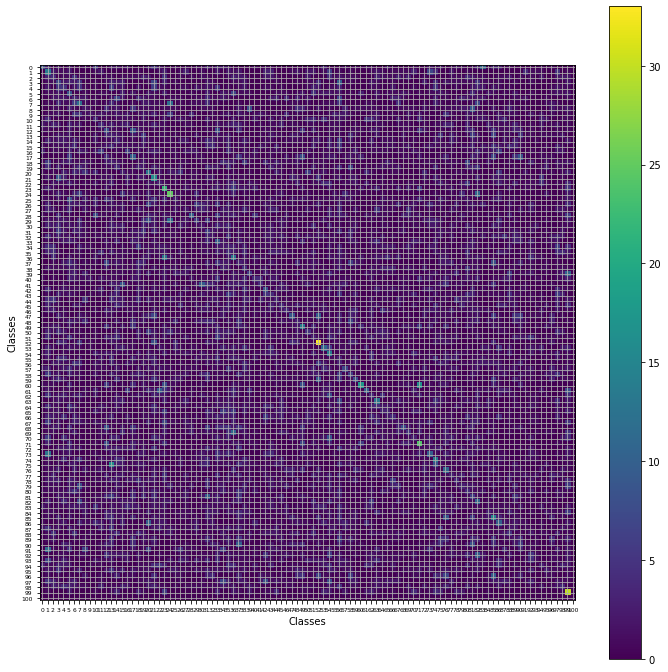

In [ ]:
# ==============
# Evaluate SVM
# ==============
import time

# para = [C, gamma, kernel]
def evaluate_svm(x_train, y_train, x_test, y_test, para):
  # log
  print("===========================================================")
  print("evaluate_svm(): Start SVM evaluating ")

  # Record time 
  start = time.time()

  # Training model 
  svm = SVC(C = para[0], kernel = para[2], gamma = para[1], max_iter = 600)
  svm.fit(x_train, y_train)

  # Prediction on x_test
  prediction = svm.predict(x_test)

  # Record time 
  end = time.time()
  time_diff = str(round((end - start)/60, 2))
  print("evaluate_svm(): time cost = " + time_diff + " minutes")

  # Plot result matrix 
  confusion = draw_confusion_matrix(y_test, prediction)

  # Accuracy, recall 
  acc = accuracy(y_test, prediction)
  rec = recall(y_test, prediction)
  pre = precision(y_test, prediction)
  f1 = F1(y_test, prediction)

  # log 
  print("evaluate_svm(): Accuracy = " + str(acc))
  print("evaluate_svm(): Recall = " + str(rec))
  print("evaluate_svm(): Precise = " + str(pre))
  print("evaluate_svm(): F1-score = " + str(f1))

  return svm

default_svm_best_para = [3, 3, 'rbf']

# evaluate SVM
if ('svm_best_para' in locals().keys()):
  svm_best_model = evaluate_svm(svm_x_train, svm_y_train, svm_x_test, svm_y_test, svm_best_para)
else:
  svm_best_model = evaluate_svm(svm_x_train, svm_y_train, svm_x_test, svm_y_test, default_svm_best_para)

#### 5.3 Evaluate LeNet-5

evaluate_LeNet(): Start LeNet evaluating 
evaluate_LeNet(): time cost = 17.04 minutes
evaluate_LeNet(): Accuracy = 0.5048
evaluate_LeNet(): Recall = 0.5048
evaluate_LeNet(): Precise = 0.5354509197653915
evaluate_LeNet(): F1-score = 0.4942434896868264


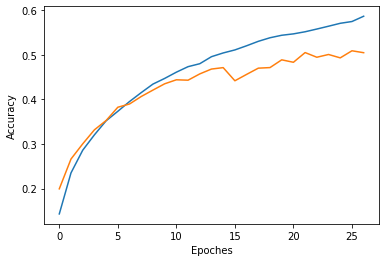

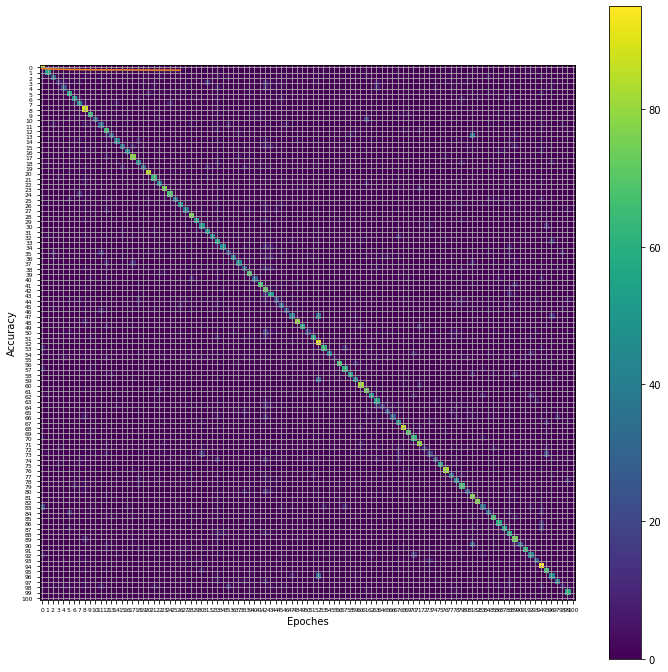

In [ ]:
#==================
# Evaluate LeNet-5
#==================
def evaluate_LeNet(x_train, y_train, x_test, y_test, para):
  print("===========================================================")
  print("evaluate_LeNet(): Start LeNet evaluating ")

  start = time.time()

  # parameters 
  best_lr = para[0]
  best_batch = para[2]
  opt = para[1]

  lenet = LeNet(drop = 0.2, summary = False)
  lenet, record = train_LeNet(x_train, y_train, 
              x_test, y_test, 
              lenet, opt = opt,
              batch_size = best_batch, max_epoch = 50, 
              early_stop = True, plot = True, 
              verb = 0)

  # predict on test data 
  prediction = lenet.predict(x_test) 

  # Record time 
  end = time.time()
  time_diff = str(round((end - start)/60, 2))
  print("evaluate_LeNet(): time cost = " + time_diff + " minutes")

  arg_pred=np.argmax(prediction, axis=1)
  arg_test=np.argmax(y_test, axis=1)

  # Plot result matrix 
  draw_confusion_matrix(arg_test, arg_pred)

  # Accuracy, recall 
  acc = accuracy(arg_test, arg_pred)
  rec = recall(arg_test, arg_pred)
  pre = precision(arg_test, arg_pred)
  f1 = F1(arg_test, arg_pred)

  # log 
  print("evaluate_LeNet(): Accuracy = " + str(acc))
  print("evaluate_LeNet(): Recall = " + str(rec))
  print("evaluate_LeNet(): Precise = " + str(pre))
  print("evaluate_LeNet(): F1-score = " + str(f1))

  plot_epoch_accuracy(record)

  return lenet

default_LeNet_best_para = [0.1, Adadelta(learning_rate = 0.1), 32]
# evaluate CNN
if ('LeNet_best_para' in locals().keys()):
  LeNet_best_model = evaluate_LeNet(NN_x_train, NN_y_train, NN_x_test, NN_y_test, LeNet_best_para)
else:
  LeNet_best_model = evaluate_LeNet(NN_x_train, NN_y_train, NN_x_test, NN_y_test, default_LeNet_best_para)

#### 5.3 Evaluate VGG-16

evaluate_VGG16(): Start VGG16 evaluating 


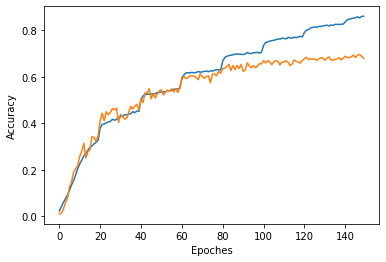

evaluate_VGG16(): time cost = 82.28 minutes
10000
10000
evaluate_VGG16(): Accuracy = 0.6786
evaluate_VGG16(): Recall = 0.6786
evaluate_VGG16(): Precise = 0.6972203598526282
evaluate_VGG16(): F1-score = 0.6796176198617497


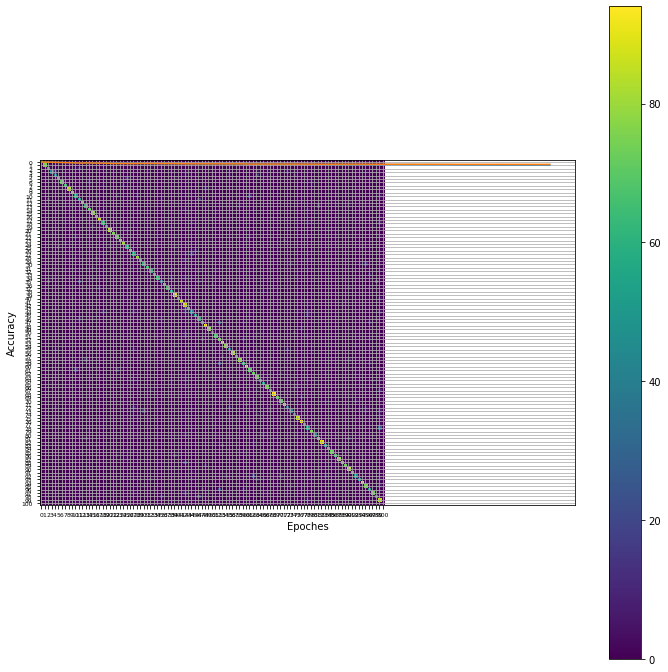

In [24]:
import time 

#================
# Evaluate VGG16
#================

# [decay, lr, batch_size]
def evaluate_VGG16(x_train, y_train, x_test, y_test, para):
  print("===========================================================")
  print("evaluate_VGG16(): Start VGG16 evaluating ")
  # record time 
  start = time.time()

  # parameters 
  best_decay = para[0]
  best_lr = para[1]
  best_batch = para[2]

  # train model 
  VGG_16 = VGG16(kernel = 3, decay = best_decay, summary = False)
  VGG_16, record = train_VGG16(x_train, y_train, 
              x_test, y_test, 
              VGG_16, learning_rate = best_lr, 
              batch_size = best_batch, max_epoch = 140, 
              early_stop = False, plot = True, 
              verb = 0)
  # predict on test data 
  prediction = VGG_16.predict(x_test) 

  # Record time 
  end = time.time()
  time_diff = str(round((end - start)/60, 2))
  print("evaluate_VGG16(): time cost = " + time_diff + " minutes")

  arg_pred=np.argmax(prediction, axis=1)
  arg_test=np.argmax(y_test, axis=1)
  print(len(arg_pred))
  print(len(arg_test))

  # Plot result matrix 
  draw_confusion_matrix(arg_test, arg_pred)

  # Accuracy, recall 
  acc = accuracy(arg_test, arg_pred)
  rec = recall(arg_test, arg_pred)
  pre = precision(arg_test, arg_pred)
  f1 = F1(arg_test, arg_pred)

  # log 
  print("evaluate_VGG16(): Accuracy = " + str(acc))
  print("evaluate_VGG16(): Recall = " + str(rec))
  print("evaluate_VGG16(): Precise = " + str(pre))
  print("evaluate_VGG16(): F1-score = " + str(f1))

  plot_epoch_accuracy(record)

  return VGG_16



default_VGG16_best_para = [0.0005, 0.1, 128]

# evaluate VGG16
if ('VGG16_best_para' in locals().keys()):
  VGG16_best_model = evaluate_VGG16(NN_x_train, NN_y_train, NN_x_test, NN_y_test, VGG16_best_para)
else:
  VGG16_best_model = evaluate_VGG16(NN_x_train, NN_y_train, NN_x_test, NN_y_test, default_VGG16_best_para)

# 6. Save model and Run saved model 
Save model will save the best model into h5 file.

#### 6.1 Save model

In [ ]:
from google.colab import files

def save_model(model):
  # download to local
  model.save('/group46_best_model.h5')
  files.download('/group46_best_model.h5')

save_model(VGG16_best_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 6.2 Load model and evaluate

In [ ]:
path = '/group46_best_model.h5'

# load best model from google colab
def load_best_model(path):
  model = tf.keras.models.load_model(path)
  return model

best_model = load_best_model(path)

# predict on testset using best model 
def prediction_on_test(x_test, y_test, model):
  prediction = model.predict(x_test)
  return prediction 

pred = prediction_on_test(NN_x_test, NN_y_test, best_model)
   
# evaluate best model 
def evaluate_saved_model(prediction, y_test):
  arg_pred=np.argmax(prediction, axis=1)
  arg_test=np.argmax(y_test, axis=1)

  acc = accuracy(arg_test, arg_pred)
  rec = recall(arg_test, arg_pred)
  pre = precision(arg_test, arg_pred)
  f1 = F1(arg_test, arg_pred)

  # log 
  print("evaluate_best_model(): Accuracy = " + str(acc))
  print("evaluate_best_model(): Recall = " + str(rec))
  print("evaluate_best_model(): Precise = " + str(pre))
  print("evaluate_best_model(): F1-score = " + str(f1))


evaluate_saved_model(pred, NN_y_test)


evaluate_best_model(): Accuracy = 0.6895
evaluate_best_model(): Recall = 0.6894999999999999
evaluate_best_model(): Precise = 0.7029080967633229
evaluate_best_model(): F1-score = 0.6899226310581206


#### 6.3 Clean up 

In [3]:
# Close existing session 
print("Clean_up()")
session = get_session()
clear_session()

# free RAM
session.close()


Clean_up()
